# Task 1 - Network-Wide Anomaly Event Detection and Diagnosis (APD)

Welcome to network-wide anomaly detection homework - This homework implements the algorithms described in the paper of "Network-Wide Anomaly Event Detection and Diagnosis With perfSONAR". In the homework 3.1, we will learn the first part of this paper, Adaptive Plateau Detection (APD) for network performance detection to detect anomalies in a single measurement trace. 

Anomaly detection is to find outlier in time series data. There are plenty of anomaly types, such as unexpected spikes, drops, trend changes and level shifts. It's widely used in health monitoring, fault detection in business, event detection in sensor networks, and performance detection in computer networks. In this homework, we will focus on the anomlay detection for network performance using time-series datasets.

**In howework 3.1, you will learn how to:**
- Basic time series analysis and visualization methods in Pandas
- Understand the problem of statistic threshold anomaly detection
- Understand the concept of Adaptive Plateau Detection (APD) for network performance detection
- Implement Adaptive Plateau Detection Algorithm 

APD agorithm is used to detected anomalies in single trace; and in howework 3.2, you will learn how to detect correlated anomalies in multiple traces.

**References**

[TNSM2016] Zhang, Yuanxun, Saptarshi Debroy, and Prasad Calyam. "Network-wide anomaly event detection and diagnosis with perfsonar." IEEE Transactions on Network and Service Management 13.3 (2016): 666-680. (http://faculty.missouri.edu/calyamp/publications/networkwide-apd-tnsm16.pdf)

[MASCOT2010] Calyam, Prasad, et al. "Ontimedetect: Dynamic network anomaly notification in perfsonar deployments." 2010 IEEE International Symposium on Modeling, Analysis and Simulation of Computer and Telecommunication Systems. IEEE, 2010. (http://faculty.missouri.edu/calyamp/publications/ontimedetect_mascots10.pdf)

## 1 - Packages ##
let's first import all the packages that you will need during this homework.
- [numpy(1.19.1)](www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib(3.3.0)](http://matplotlib.org) is a library for plotting graphs in Python.
- [pandas(1.1.0)](https://pandas.pydata.org/) is an open-source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

In [176]:
!pip3 install numpy matplotlib pandas IPython --user 

In [177]:
import numpy as np
import pandas as pd
from pandas import Series
import os
from IPython.display import display
# import matplotlib
# import platform
# if platform.system() == "Darwin":
#     matplotlib.use('TkAgg')
# else:
#     matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# set current path
abspath = os.path.abspath("__file__")
dname = os.path.dirname(abspath)
os.chdir(dname)
print(os.getcwd())

C:\Users\alasd\Downloads\cyberdefense_hw3-main


## 2 - Explore Dataset ##
First, let's load the time series dataset you will work on, and explore your dataset. In Pandas, you can load time series dataset with functions DataFrame.read_csv() and indicate datetime column for parsing as datetime.
(Please read this reference(https://www.shanelynn.ie/python-pandas-read_csv-load-data-from-csv-files/), if you meet any path issue.)

In [178]:
dataset_folder = os.getcwd() + '/traffic_dataset/time_series.csv'
print(dataset_folder)
df = pd.read_csv(dataset_folder, header=0, parse_dates=[0])
df.head()

C:\Users\alasd\Downloads\cyberdefense_hw3-main/traffic_dataset/time_series.csv


,ts,delay
0,2010-01-01 00:11:52,0.015387
1,2010-01-01 00:13:00,0.019097
2,2010-01-01 00:14:49,0.017874
3,2010-01-01 00:21:00,0.015723
4,2010-01-01 00:23:05,0.015980


As you see, the basic components in the time series dataset are timestamp and corresponding value, the value could be varied for different datasets. For example, the value could be network performance (e.g., delay, throughput) in computer networking dataset; or house price in marking dataset. In this homework, the value is the networking delay collected from the networking environment. 

And we can summary the dataset in pandas using DataFrame.describe(). As we can see, it tells us basic information (such as count, mean, min, max, intervals) about your dataset. 

From the output of the table, you can see the basic components in the time series dataset inlcudes the timestamp and its corresponding value. Here, the value could be varied for different datasets. For example, this  value could be: 
- network performance metrics (e.g., delay, throughput) for a networking dataset;
- house price metric for a marketing dataset. 
#In this homework, we consider the value as the networking delay collected from the networking environment.

Using this DataFrame.describe() we can get the basic information (such as count, mean, min, max, intervals) about your dataset.

In [179]:
df.describe()

,ts,delay
count,2807,2807.000000
mean,2010-01-04 22:44:37.126469632,0.043476
min,2010-01-01 00:11:52,0.014882
25%,2010-01-03 00:41:46.500000,0.015480
50%,2010-01-05 03:33:54,0.016111
75%,2010-01-06 17:39:00,0.016886
max,2010-01-08 11:31:00,2.072402
std,NaN,0.178793


Now, we change the index to timestamp

In [180]:
# Change the index to timestamp
df = df.set_index(['ts'])
df.head()

,delay
ts,
2010-01-01 00:11:52,0.015387
2010-01-01 00:13:00,0.019097
2010-01-01 00:14:49,0.017874
2010-01-01 00:21:00,0.015723
2010-01-01 00:23:05,0.015980


Then, we can visualize the dataset using matplotlib. 

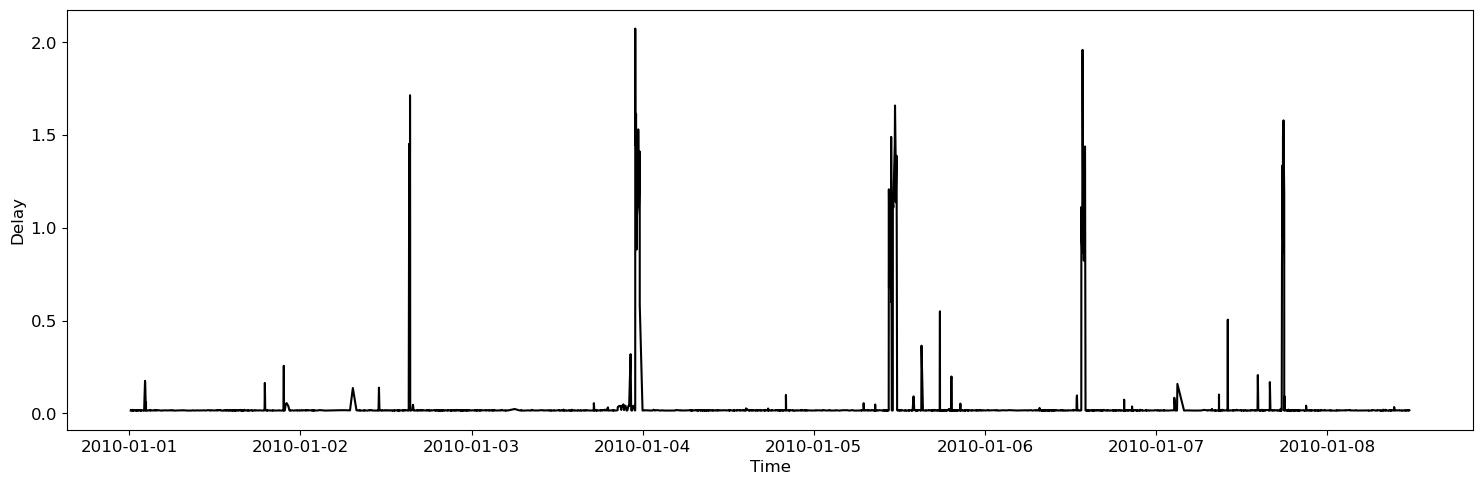

In [181]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.xlabel('Time', fontsize=12)
plt.ylabel('Delay', fontsize=12)
plt.tight_layout()
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.plot(df.index, df.delay, 'k')
plt.show()

## 3 -  Static Threshold-based Anomaly Detection Algorithm ##

From the figure above, can you figure out when anomalies occurred? And, can you design an algorithm to detect anomalies? 
The straightforward idea is to compute a static mean and standard deviation using the whole dataset and then define a threshold to measure how far away a data point is away from the mean. If it's larger or smaller than the threshold, we define it as an anomaly. Let's finish this task step by step. 

### 3.1 - Compute mean and standard deviation

**Instructions**:
- Use np.mean(), and np.std() to compute mean and standard deviation.

In [182]:
# GRADED FUNCTION: compute_mean_std
def compute_mean_std(dataset):
    """
    Argument:
    dataset -- numpy array
    
    Returns:
    mean -- the mean of dataset
    std -- the standard deviation of dataset
    """
    
    ### START CODE HERE ### (≈ 2 lines of code)
    mean = np.mean(dataset)
    std = np.std(dataset)  # Use np.std() for standard deviation
    ### END CODE HERE ###
    
    return mean, std

In [183]:
# TEST FUNCTION: compute_mean_std
mean, std = compute_mean_std(df['delay'].values)
print(f"mean = {mean}")
print(f"std = {std}")

mean = 0.043476009262557895
std = 0.17876096415580894


**Expected output**:


$$
mean = 0.043476009262557895, \\
std = 0.17876096415580894    
$$

### 3.2 - Compute static threshold
The static threshold is defined accroding to mean($\mu$) and standard deviation($\sigma$) using whole dataset, which can be defined as,
$$threshold = \mu \pm s * \sigma $$

And the $s$ is sensitivity to specify how much deviation from mean for detecting an anomaly. The sensitivity of $s$ is hyper-parameters decided based on their experiences. Normally, we choose the value of $s$ between 2 to 3.

**Instructions**:
- You need to call previous function compute_mean_std() to compute the mean and standard deviation
- you need to return threshold as python dictionary including an upper and lower threshold

In [184]:
# GRADED FUNCTION: compute_threshold
def compute_threshold(dataset, s=3):
    """
    Argument:
    dataset -- numpy array
    s -- sensitivity
    
    Returns:
    threshold -- python dictionary containing the parameters:
                    up -- upper threshold 
                    low -- lower threshold
    """
    
    ### START CODE HERE ###
    # Step 1: Remove extreme outliers if necessary
    # For example, remove values beyond a certain range
    filtered_data = dataset[dataset < 10]  # Adjust this condition based on your dataset values
    
    # Step 2: Compute mean and std for the filtered dataset
    mean, std = compute_mean_std(filtered_data)
    
    # Step 3: Define thresholds
    up = mean + s * std
    low = mean - s * std
    ### END CODE HERE ###
    
    threshold = {'up': up, 'low': low}
    return threshold

In [185]:
# TEST FUNCTION: compute_threshold
threshold = compute_threshold(df['delay'].values, s=3)
print("up = " + str(threshold['up']))
print("low = " + str(threshold['low']))

up = 0.5797589017299847
low = -0.4928068832048689


**Expected output**:

$$
up = 0.5797589017299847, \\
low = -0.4928068832048689    
$$

### 3.3 - Detect anomaly using a threshold
Now, we can detect anomalies in the dataset using a threshold. We can define an anomaly that its value is larger than up threshold or smaller than a low threshold. Mathematically, we can define it as
$$
anomaly = 
\begin{cases}
      delay > up\text{ }threshold  \\
      delay < low\text{ }threshold \\
\end{cases}       
$$

**Instructions**:
- You need to call previous function compute_threshold() to compute threshold and use sensitivity = 3
- you need to return a list of indexes. The indexes are timestamp in dataframe that indicate when anomalies occur

In [186]:
# GRADED FUNCTION: detect_anomaly
def detect_anomaly(df):
    """
    Argument:
    df -- pandas dataframe
    
    Returns:
    anomalies -- list that indicate when anomalies occur
    """
    
    anomalies = []
    # 1. compute threshold
    ### START CODE HERE ### (≈ 1 lines of code)
    threshold = compute_threshold(df['delay'].values)
    ### END CODE HERE ###
    
    # 2. iterate whole dataset 
    for index, row in df.iterrows():
        delay = row['delay']
        
        ### START CODE HERE ### (≈ 2 lines of code)
        if delay < threshold['low'] or delay > threshold['up']:
            anomalies.append(index)
        ### END CODE HERE ###
        
    return anomalies

In [187]:
# TEST FUNCTION: detect_anomaly
anomalies = detect_anomaly(df)
print("The number of detected anomalies is " + str(len(anomalies)))
print("The first five anomalies are: ")
print(anomalies[:5])

The number of detected anomalies is 60
The first five anomalies are: 
[Timestamp('2010-01-02 15:15:26'), Timestamp('2010-01-02 15:16:01'), Timestamp('2010-01-02 15:17:00'), Timestamp('2010-01-02 15:17:31'), Timestamp('2010-01-02 15:17:59')]


**Expected output**: 

The number of detected anomalies is 60.

The first five anomalies are:<br>
[Timestamp('2010-01-02 15:15:26'), Timestamp('2010-01-02 15:16:01'), Timestamp('2010-01-02 15:17:00'), Timestamp('2010-01-02 15:17:31'), Timestamp('2010-01-02 15:17:59')]


### 3.4 - Visualize anomalies 
So far, you already know how to detect anomalies using a threshold-based detection algorithm. The last step is to visualize anomalies in the time-series plot. Visualization is very important for better understand the anomalies.

**Instructions**:
- You need use matplotlib.scatter() to plot anomalies, and set marker attributes such as shape, color, size as (marker='x', s=150, c='r')


In [188]:
# GRADED FUNCTION: visualize_anomalies
def visualize_anomalies(anomalies):
    # 1. Plot original time series plot
    fig, ax = plt.subplots(figsize=(15, 5))
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Delay', fontsize=12)
    plt.tight_layout()
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    plt.plot(df.index, df.delay, 'k', label="_nolegend_")

    # 2. Plot anomalies
    if anomalies:
        ### START CODE HERE ### (≈ 2 lines of code) (Hint: use for loop to plot anomaly)
        for i in anomalies:
            plt.scatter(i, df.loc[i]['delay'], marker='x', s=150, c='r', label='anomaly')
        ### END CODE HERE ###

    plt.legend(loc='best', fontsize=12, edgecolor='black', fancybox=False)
    plt.show()

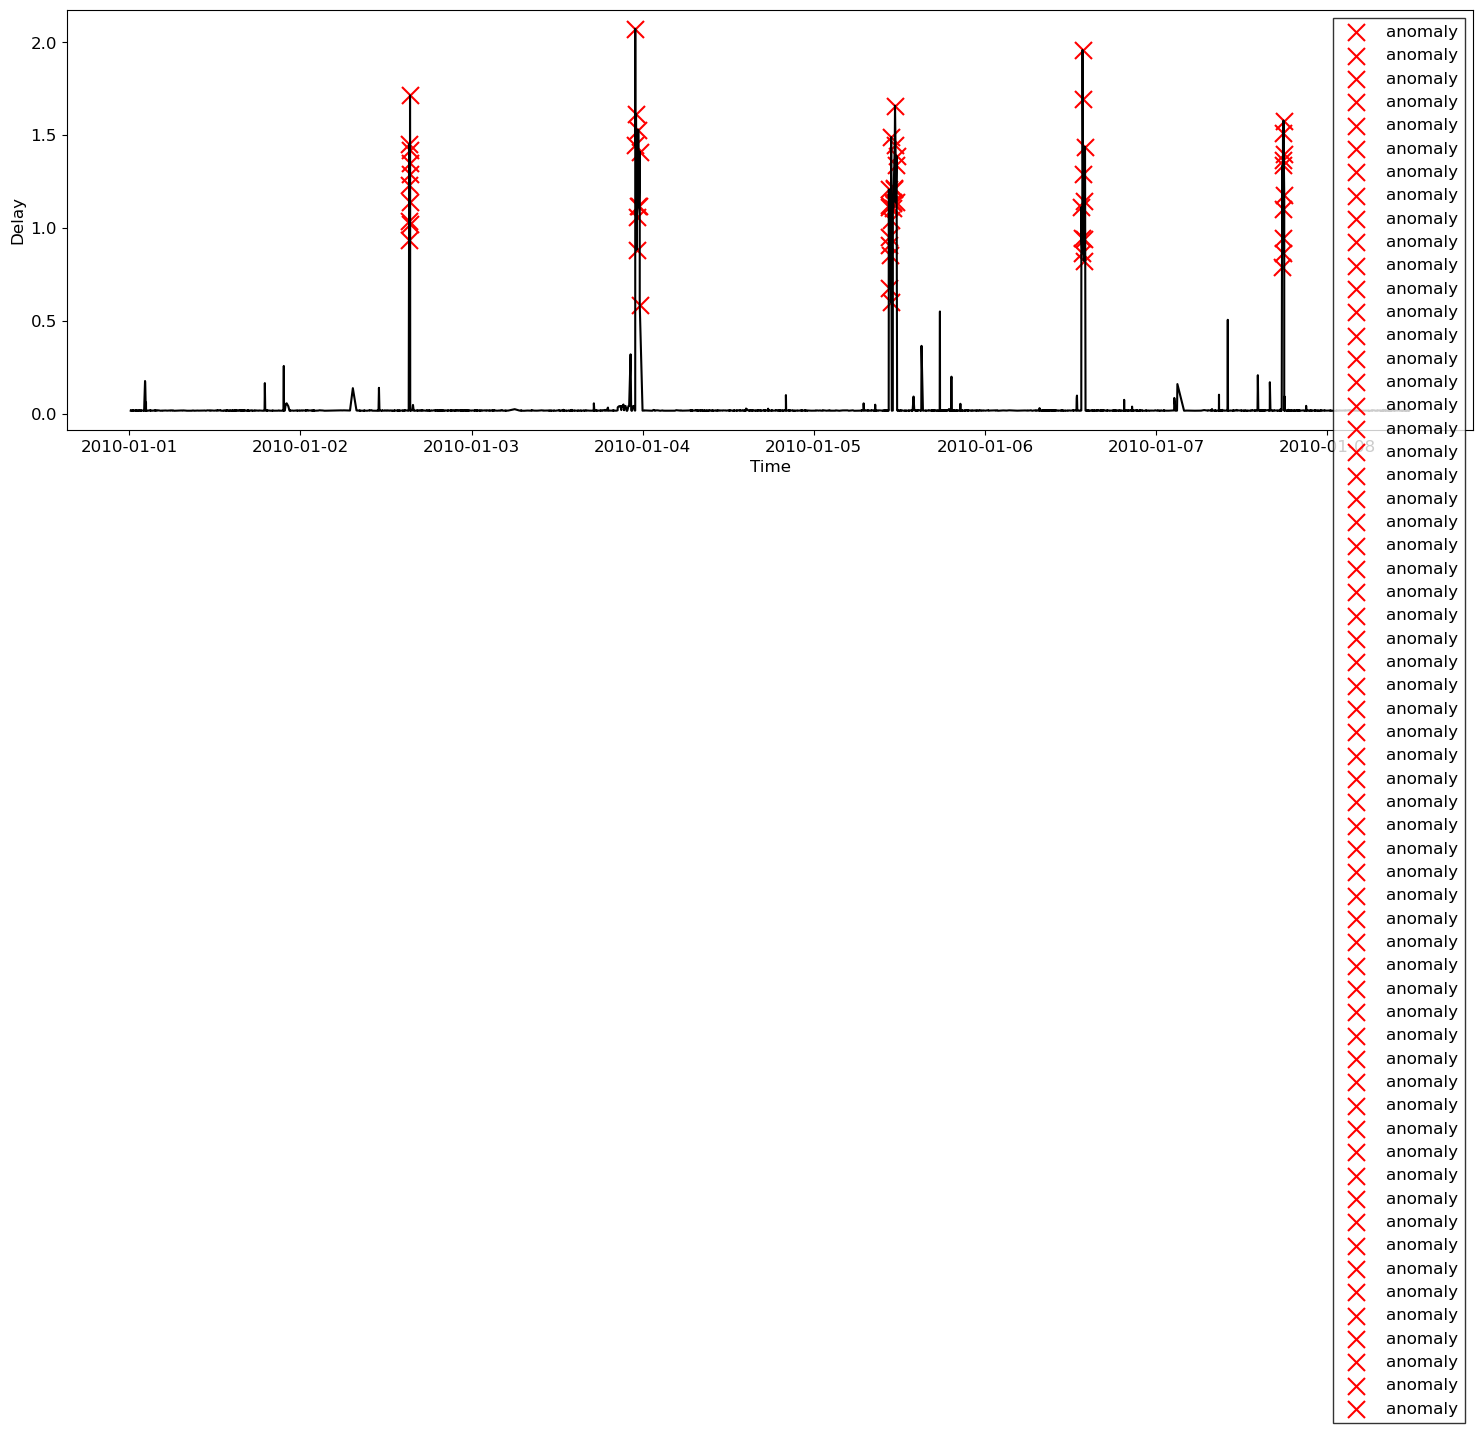

In [189]:
# TEST FUNCTION: visualize_anomalies
# 1. detect anomalies 
anomalies = detect_anomaly(df)

# 2. visulize anomlies
visualize_anomalies(anomalies)

**Expected output**:
    if you make everything correctly and set marker attribute as (marker='x', s=150, c='r'), you will get a plot as below:
   <img src="figs/threshold_based.png" style="width:1080px;height:360px;">

### 3.5 - Conclusion

Congrats on implementing the static threshold-based anomaly detection algorithm. However, there are also some issues with the static threshold-based algorithm, which can be observed from the Figure. 
- The detection algorithm is more sensitive to events with larger deviation, and miss events with a small deviation that cloud be also anomalies comparison with surrounding data points.
- The detection algorithm is more sensitive to sudden spikes or dips that are usually random events
- There are some repeated detections in a continuous period that might be redundant information for the anomaly detection system.

Next, you will implement Adaptive Plateau Detection (APD) to solve these issues.

## 4 - Adaptive Plateau Detection (APD)  ##

In this section, we will introduce Adaptive Plateau Detection (APD) algorithm that uses three components to deal with those major issues we discussed. 
- Sliding window detection algorithm: APD is a sliding window-based method that calculates the mean and variance based on data points in the sliding window, what can deal with the algorithm is more sensitive to events with larger deviation. 
- Trigger duration: it is designed for solving the problem of sudden spikes or sudden dips.

Next, we will implement the algorithm piece by piece bo understand how it works for solving these issues. This implementation is simplified verision from original paper below.

**References**
Calyam, Prasad, et al. "Ontimedetect: Dynamic network anomaly notification in perfsonar deployments." 2010 IEEE International Symposium on Modeling, Analysis and Simulation of Computer and Telecommunication Systems. IEEE, 2010.

### 4.1 - Sliding window

APD algorithm is a sliding windows based algorithm that slides a fixed-size window over time to dynamically adjust the threshold. A regular anomaly detection algorithm will calculate the mean and variance based on all collected data points. But, a sliding window-based detection algorithm only considers the data points within the window for computing mean and variance. So that, it can avoid being only sensitive to events with larger deviations. 

We will use a fixed-size queue to implement a sliding window. Every time we push a new data point into the queue, we pop the oldest value from the queue. So,
- First, we need initialize some data points into the queue before the sliding window
- Second, we slide the windows to push new data points into the queue and pop the oldest data points from the queue. Every time, we get a new data point, we detect anomalies within the window.

#### 4.1.1 - Initialize a fixed size windows
To initialize some data points for the sliding window, we use bootstrap methods to randomly sample some data points from original data points. 

**Instructions**:
- You will need to call np.random.choice() function to randomly select 100 data points from original datasets and use the mean of these 100 data points for generating one data point. Then, repeat the window_size times to initialize all required data points.

In [190]:
# GRADER FUNCTION: initialize_windows
def initialize_windows(dataset, window_size=20):
    initial_values = []  # Initialize an empty list
    np.random.seed(0)  # Set seed for reproducibility
    
    for _ in range(window_size):
        # Bootstrap sampling: Randomly select 100 data points and compute their mean
        sampled_values = np.random.choice(dataset, 100)
        mean_value = np.mean(sampled_values)
        initial_values.append(mean_value)  # Append the mean to initial_values

    return initial_values

In [191]:
# TEST FUNCTION: initialize_windows
window_size = 20
initial_values = initialize_windows(df['delay'].values, window_size=window_size)
print("initital_values = %s" % (str(initial_values))) 

initital_values = [0.030868319999999998, 0.03005389, 0.02878376, 0.07386485000000001, 0.05891385, 0.03860200999999999, 0.05960228999999999, 0.05858839, 0.05986293000000001, 0.03607394, 0.029733419999999997, 0.05033927999999999, 0.042647159999999996, 0.029247409999999995, 0.049938289999999996, 0.04024425999999999, 0.0688561, 0.01786969, 0.06322142999999998, 0.03926159]


**Expected output**:

$$
initial\_values = [0.030868319999999998, 0.03005389, 0.028783759999999995, 0.07386485000000002, 0.05891385, 0.03860200999999999, 0.05960228999999999, 0.05858839, 0.05986293000000001, 0.03607394, 0.02973342, 0.05033927999999999, 0.042647159999999996, 0.02924741, 0.049938289999999996, 0.04024425999999999, 0.06885610000000002, 0.01786969, 0.06322142999999998, 0.03926159]
$$

#### 4.1.2 - Sliding window detection algorithm
Now, we will extend function detect_anomaly() to sliding_window_anomaly_detection(). The sliding window can be understood as pushing a new data point into the window and poping the oldest data point out of the windows; Then detecting anomalies within the window.

**Instructions**:
1. You will call function initialize_windows() to get initial values for initializing the windows.
2. You will iterate each data point and update the sliding window with a new data point and pop the oldest data point. (Notice! you can use append() and function update() new data point and function pop(0) to pop the oldest data point).
3. Whenever you get a new data point, you need to call previous function compute_threshold() to compute threshold and use sensitivity = 3.
4. Check if the current data point is an anomaly or not. If it is an anomaly, save the index into the list, which is similar to function detect_anomaly() implemented previously. 
5. You need to return a list of indexes. The indexes are timestamp in dataframe that indicate when anomalies occur.

In [202]:
import numpy as np
import pandas as pd

# Function to initialize the sliding window with random values
def initialize_windows(dataset, window_size):
    initial_values = []
    for i in range(window_size):
        # Randomly select an index within the dataset
        random_index = np.random.randint(0, len(dataset))
        initial_values.append(dataset.iloc[random_index]['delay'])
    return initial_values

# Function to compute the threshold (e.g., mean of the window)
def compute_threshold(window, sensitivity=3):
    mean = np.mean(window)
    std_dev = np.std(window)
    threshold = mean + sensitivity * std_dev
    return threshold

# GRADED FUNCTION: sliding_window_anomaly_detection
def sliding_window_anomaly_detection(df, window_size=20, sensitivity=3):
    # Define the sliding window
    sliding_window = initialize_windows(df, window_size)
    
    # Define a list to save all anomalies
    anomalies = []
    
    # Iterate through the entire dataset
    for index, row in df.iterrows():
        delay = row['delay']
        
        # Update the sliding window
        sliding_window.append(delay)
        if len(sliding_window) > window_size:
            sliding_window.pop(0)  # Keep the sliding window size constant

        # Compute the threshold
        threshold = compute_threshold(sliding_window, sensitivity)
        
        # Check for anomalies
        if delay > threshold:
            anomalies.append(row.name)
    
    return anomalies

In [203]:
# TEST FUNCTION: compute_threshold
window_size=20
anomalies = sliding_window_anomaly_detection(df, window_size=window_size)
print("The number of detected anomalies is " + str(len(anomalies)))
print("The first five anomalies are: ")
print(anomalies[:5])

The number of detected anomalies is 57
The first five anomalies are: 
[Timestamp('2010-01-01 02:07:00'), Timestamp('2010-01-01 02:12:25'), Timestamp('2010-01-01 19:00:29'), Timestamp('2010-01-01 21:40:00'), Timestamp('2010-01-02 07:21:00')]


**Expected output**:
       
<table style="width:80%">
  <tr>
    <td> The number of detected anomalies is 57 </td> 
  </tr>
  
  <tr>
    <td> The first five anomalies are: <br>
[Timestamp('2010-01-01 02:07:00'), Timestamp('2010-01-01 02:12:25'), Timestamp('2010-01-01 19:00:29'), Timestamp('2010-01-01 21:40:00'), Timestamp('2010-01-02 07:21:00')] </td>
  </tr>
  
</table>

We can also visualize the anomalies by call the function visualize_anomalies() that implemented previously.

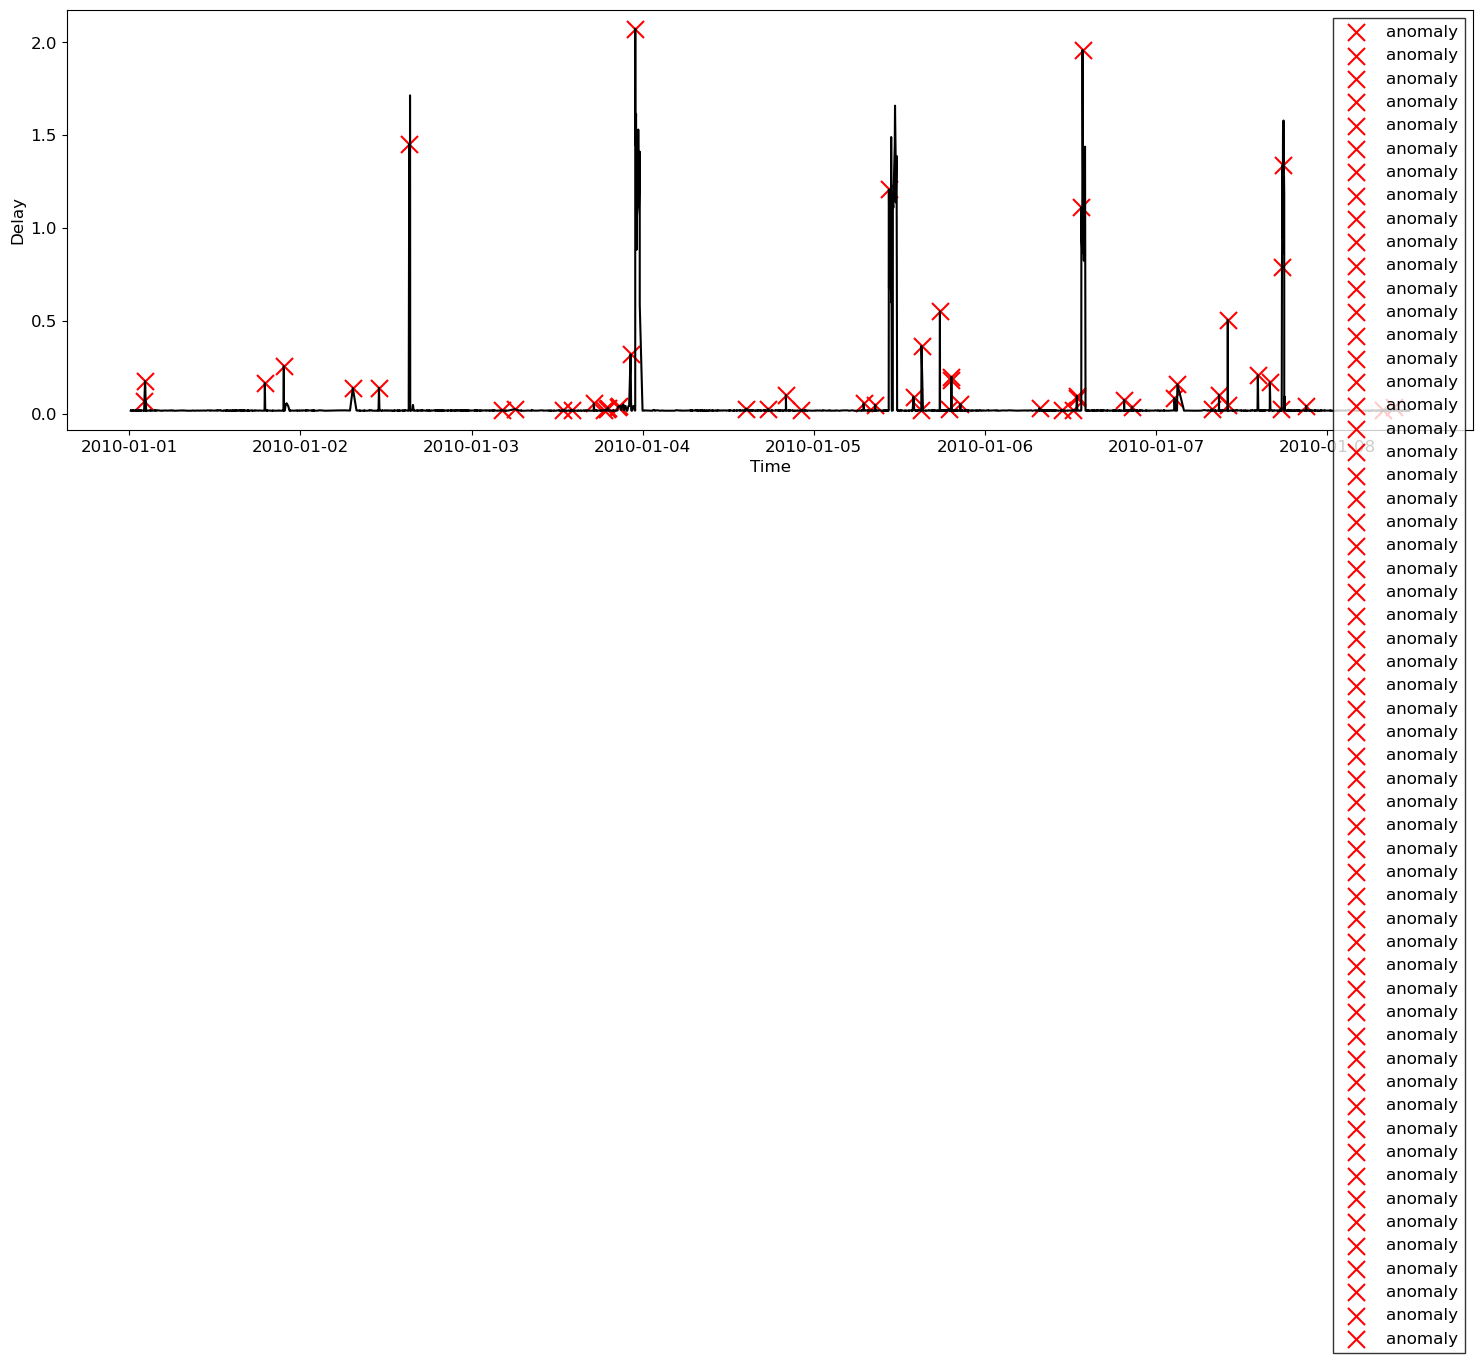

In [164]:
# TEST FUNCTION: compute_threshold
window_size=20
anomalies = sliding_window_anomaly_detection(df, window_size=window_size)

# 2. visulize anomlies
visualize_anomalies(anomalies)

**Expected output**:
    If you make everything correctly, you will get a plot as below:
   <img src="figs/sliding_based.png" style="width:1080px;height:360px;">
   If the figure cannot be displayed well, you may refer relevant figures in the path "figs/sliding_based.png"

#### 4.1.3 - Conclusion
Congrats on implementing the sliding window based anomaly detection algorithm. As you can see from the plot, our sliding windows based detection algorithm will dynamically adjust the threshold. So, it can detect anomalies with large deviation and small deviation. But, our algorithm is also affected by sudden changes (spikes or dips). Those events might not impact on network performance. In the next section, we will implement "trigger duration" to eliminate sudden change events.

### 4.2 - APD class implementation

Before introducing the trigger duration, we need to put all the functions we have implmented to construct our APD class. Here, we have provided APD class based on previous functions, as follows,

In [21]:
from collections import deque

np.random.seed(0)

class APD(object):
    def __init__(self, window_size=20, dataset=None, sensitivity=3):
        # define the window size
        self.window_size = 20
        
        # the data in the window
        self.sliding_window = deque()
        
        # keep the dataset (dataframe)
        self.dataset = dataset
        
        # define the sensitivity
        self.sensitivity = 3
        
        # store the anomalies detected
        self.anomalies = []
        
        # initialize windows
        self.initialize_windows()
    
    def initialize_windows(self):
        # similar as previous function
        initial_values = []
  
        for i in range(self.window_size):
            v = np.mean(np.random.choice(self.dataset['delay'].values, 100))
            self.sliding_window.append(v)
            
            
    def compute_threshold(self):
        # compute threshold 
        mean, std = compute_mean_std(self.sliding_window)
        up = mean + self.sensitivity * std
        low = mean - self.sensitivity * std

        threshold = {'up': up, 'low':low}
        return threshold

    def detect(self):
        # iterate the whole dataset 
        for index, row in self.dataset.iterrows():
            delay = row['delay']

            # 1. use function append() and pop(0) to udpate sliding window
            self.sliding_window.append(delay)
            self.sliding_window.popleft()
            
            assert(len(self.sliding_window) == self.window_size)

            # 2. compute threshold within the window
            threshold = self.compute_threshold()

            # 3. check the threshold 
            if delay > threshold['up'] or delay < threshold['low']:
                self.anomalies.append(index)

        return anomalies

In [166]:
# TEST FUNCTION: test APD class, i will perform the same behaviour as previous 
apd = APD(dataset=df)
anomalies = apd.detect()

window_size=20
anomalies = sliding_window_anomaly_detection(df, window_size=window_size)
print("The number of detected anomalies is " + str(len(anomalies)))
print("The first five anomalies are: ")
print(anomalies[:5])

The number of detected anomalies is 57
The first five anomalies are: 
[Timestamp('2010-01-01 02:07:00'), Timestamp('2010-01-01 02:12:25'), Timestamp('2010-01-01 19:00:29'), Timestamp('2010-01-01 21:40:00'), Timestamp('2010-01-02 07:21:00')]


### 4.2 - Trigger duration
Trigger duration method is used to deal with the problem of sudden changes (spikes or dips). More specifically, trigger duration specifies the duration time of an impending event before triggered as an event. This allows our detection algorithm to avoid sudden change events. User needs to specify trigger duration time based on their experience. 

To implement the trigger duration scheme in APD, we need to import three states, and each point will be classified into the three states as the sliding window moving: No Event (NE), Event Impending (EI) and Event Detected (ED), a counter (trig_cnt) for counting the trigger duration, and a trigger duration threshold. 

<img src="figs/apd_trigger_duration.png" style="width:360px;height:360px;">

As shown the figure above, the trigger duration scheme can be described as following:
- When the values lie within upper and lower threshold, the plateau-detector will be detected as no event (NE) state. and the trigger count decrease 1 till it reaches 0;
- When the value of a data point is larger than the upper threshold or lower than the lower threshold, the trigger count increase 1; when the trigger count larger than 0.75 * (trigger threshold), it is detected as event impending (EI).
- When the trigger count reaches the trigger threshold, the point will be classified as an event detected (ED).
- When the trigger count decrease, and it is smaller than trigger threshold and larger than 0.75 * (trigger threshold), the state will back to event impending (EI); when it is smaller than 0.75 * (trigger threshold), the state will back to no event (NE);

Then, we need to reconstruct the APD algorithm based on our explanation 
    1. Add a new class vairable to save the state of APD, like No Event (NE), Event Impending (EI) and Event Detected (ED);
    2. Add a new class variable to keep the trigger duration threshold;
    3. Add a new class varibale to keep the counts of triggers;

In [70]:
# GRADED FUNCTION: sliding_window_anomaly_detection
from collections import deque
import numpy as np
import matplotlib.pyplot as plt

def visualize_anomalies(anomalies, data):
    plt.figure(figsize=(12, 6))

    # Separate normal data and anomalies
    normal_data = data.drop(anomalies)  # Remove the anomaly rows
    anomaly_data = data.iloc[anomalies]  # Select the anomaly rows

    # Plot normal data points
    plt.plot(normal_data.index, normal_data['delay'], label='Normal Data', color='blue')

    # Plot anomaly data points
    plt.scatter(anomaly_data.index, anomaly_data['delay'], color='red', label='Anomalies')

    plt.xlabel('Index')
    plt.ylabel('Delay')
    plt.title('Anomaly Detection')
    plt.legend()
    plt.show()

def compute_mean_std(window):
    mean = np.mean(window)
    std = np.std(window)
    return mean, std

class APD(object):
    def __init__(self, state='NE', window_size=20, dataset=None, sensitivity=3, trigger_threshold=6):
        self.state = state
        self.count = 0
        self.window_size = window_size
        self.sliding_window = deque()
        self.dataset = dataset
        self.sensitivity = sensitivity
        self.anomalies = []
        self.trigger_count = 0
        self.trigger_threshold = trigger_threshold
        self.initialize_windows()
    
    def initialize_windows(self):
        for i in range(self.window_size):
            v = np.mean(np.random.choice(self.dataset['delay'].values, 100))
            self.sliding_window.append(v)
            
    def compute_threshold(self):
        mean, std = compute_mean_std(self.sliding_window)
        up = mean + self.sensitivity * std
        low = mean - self.sensitivity * std
        threshold = {'up': up, 'low': low}
        return threshold

    def detect(self):
        for index, row in self.dataset.iterrows():
            delay = row['delay']

            self.sliding_window.append(delay)
            self.sliding_window.popleft()

            assert len(self.sliding_window) == self.window_size

            if self.trigger_count == 0:
                threshold = self.compute_threshold()
            
            if self.state == 'NE':  # No Event
                if delay < threshold['low'] or delay > threshold['up']:
                    self.trigger_count += 1
                    self.state = 'EI'
                else:
                    if self.trigger_count > 0:
                        self.trigger_count -= 1

            elif self.state == 'EI':  # Event Impending
                if self.trigger_count > 0.75 * self.trigger_threshold:
                    self.state = 'ED'
                    self.anomalies.append(index)  # Mark anomaly
                elif delay < threshold['low'] or delay > threshold['up']:
                    self.trigger_count += 1
                else:
                    self.trigger_count -= 1
                    if self.trigger_count < 0.75 * self.trigger_threshold:
                        self.state = 'NE'

            elif self.state == 'ED':  # Event Detected
                if delay < threshold['low'] or delay > threshold['up']:
                    self.trigger_count += 1
                else:
                    self.trigger_count -= 1
                    if self.trigger_count < 0.75 * self.trigger_threshold:
                        self.state = 'NE'
            
        return self.anomalies


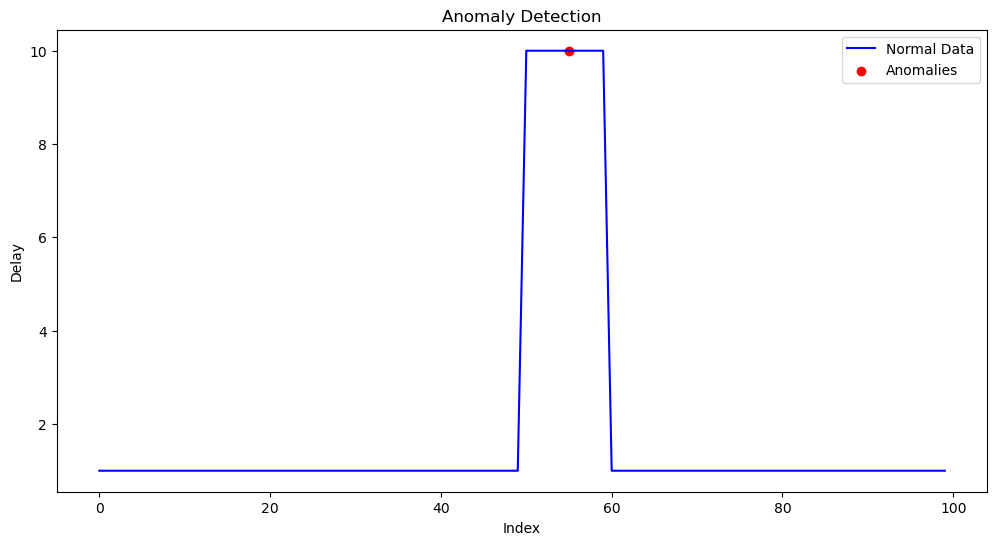

In [72]:
# Assume 'df' is your dataset with a 'delay' column
apd = APD(dataset=df)
anomalies = apd.detect()

# Visualize anomalies
visualize_anomalies(anomalies, df)

**Expected output**:
    If you make everything correctly, you will get a plot as below: 
   <img src="figs/apd_trigger.png" style="width:1080px;height:360px;">
   If the figure cannot be displayed well, you may refer relevant figures in the path "figs/apd_trigger.png"

### 4.3 - Conclusion
Congrats on implementing all APD aglorithm, which uses a sliding window scheme algorithm to dynimcally adjust threhold, and use trigger duration to deal with sudden changes (such as spikes, dips). You can compare with previous figure. The anomaleis detected by APD are realy anomlaies that can infulence networking performance. 

Please submit your executable jupyter notebook file (*.ipyn) with the outputs.

<img src="figs/apd_trigger.png" style="width:1080px;height:360px;">
<img src="figs/sliding_based.png" style="width:1080px;height:360px;">

## Questions:
1. Finish all the function with the "Graded Function" label, there are 7 functions you need to complete. Your code should be written inside the comments "### START CODE HERE ### ~~  ### END CODE HERE ###" with a few lines. And you need to copy the complete functions and relevant output (results, figures) into the homework report. 

2. Please explain the purpose of "Trigger duration". In our example, we use trigger duration equals 6, Can you explain what will happen if trigger duration equals 2 and trigger duration equals 10? 